
#### Previsão de volume do Sistema Cantareira com modelos de aprendizado de máquina
 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from prophet import Prophet
import glob

/home/jsfilho/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Companhia de Saneamento Básico do Estado de São Paulo - Sabesp

In [2]:
# Lendo arquivo SABESP_sistemas_produtores.xls

df_SABESP = pd.read_excel(
    r'SABESP_sistemas_produtores.xlsx')

In [3]:
df_SABESP

,Data,Represa,Nível (m),Volume (hm³),Volume (%),Q Jusante (m³/s),Q Natural (m³/s),Chuva (mm)
0,2006-06-30,Jaguari/Jacareí,837.45,509.998711,63.115251,2.0,12.981553,0.0
1,2006-06-29,Jaguari/Jacareí,837.49,511.647953,63.319354,2.0,18.427419,0.0
2,2006-06-28,Jaguari/Jacareí,837.52,512.886288,63.472605,2.0,13.878232,0.0
3,2006-06-27,Jaguari/Jacareí,837.56,514.539272,63.677171,2.0,42.678978,13.0
4,2006-06-26,Jaguari/Jacareí,837.54,513.712513,63.574855,2.0,6.775952,1.4
...,...,...,...,...,...,...,...,...
33959,2009-07-05,Paiva Castro,744.86,4.297412,56.455158,1.0,3.907737,0.0
33960,2009-07-04,Paiva Castro,744.89,4.425480,58.137583,1.0,3.288081,0.0
33961,2009-07-03,Paiva Castro,744.84,4.212238,55.336218,1.0,4.074494,8.8
33962,2009-07-02,Paiva Castro,744.76,3.873161,50.881769,1.0,3.500000,0.2


In [5]:
df_SABESP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33964 entries, 0 to 33963
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Data              33964 non-null  datetime64[ns]
 1   Represa           33964 non-null  object        
 2   Nível (m)         33964 non-null  float64       
 3   Volume (hm³)      33964 non-null  float64       
 4   Volume (%)        33964 non-null  float64       
 5   Q Jusante (m³/s)  33964 non-null  float64       
 6   Q Natural (m³/s)  33964 non-null  float64       
 7   Chuva (mm)        33964 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 2.1+ MB


In [4]:
df_SABESP['Represa'].unique()

array(['Jaguari/Jacareí', 'Cachoeira', 'Atibainha', 'Paiva Castro'],
      dtype=object)

In [5]:
# índices das linhas que contém valores NaN
ValNaN = pd.isnull(df_SABESP).any(axis=1).to_numpy().nonzero()

# imprime apenas as linhas com valores ausentes
display(df_SABESP.iloc[ValNaN])

,Data,Represa,Nível (m),Volume (hm³),Volume (%),Q Jusante (m³/s),Q Natural (m³/s),Chuva (mm)


In [6]:
# Principais estatísticas da base de dados
df_detalhesSabesp = df_SABESP.describe()

display(df_detalhesSabesp)

,Nível (m),Volume (hm³),Volume (%),Q Jusante (m³/s),Q Natural (m³/s),Chuva (mm)
count,33964.000000,33964.000000,33964.000000,33964.000000,33964.000000,33964.000000
mean,794.796559,107.918554,43.989486,1.475058,8.143131,3.890495
std,34.216316,185.010730,21.144810,4.172573,11.630960,9.628289
min,743.970000,-167.310740,-106.811763,0.000000,-46.991017,0.000000
25%,767.747500,4.569826,35.016609,0.250000,2.110000,0.000000
50%,798.530000,33.534372,45.740448,1.000000,4.220000,0.000000
75%,818.570000,58.876226,54.219413,1.500000,9.323181,2.000000
max,844.700000,843.085059,109.176203,110.000000,298.206401,143.200000


#### Pré-processamento: detecção de *outliers*

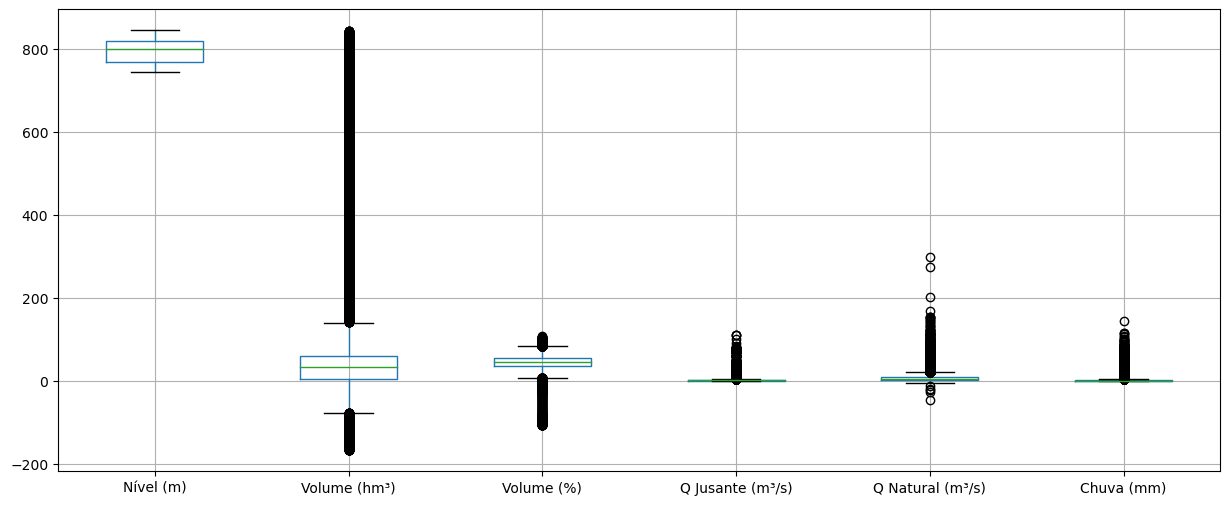

In [7]:
# gera um bloxplot para cada atributo
df_SABESP.boxplot(figsize=(15,6))
plt.show()

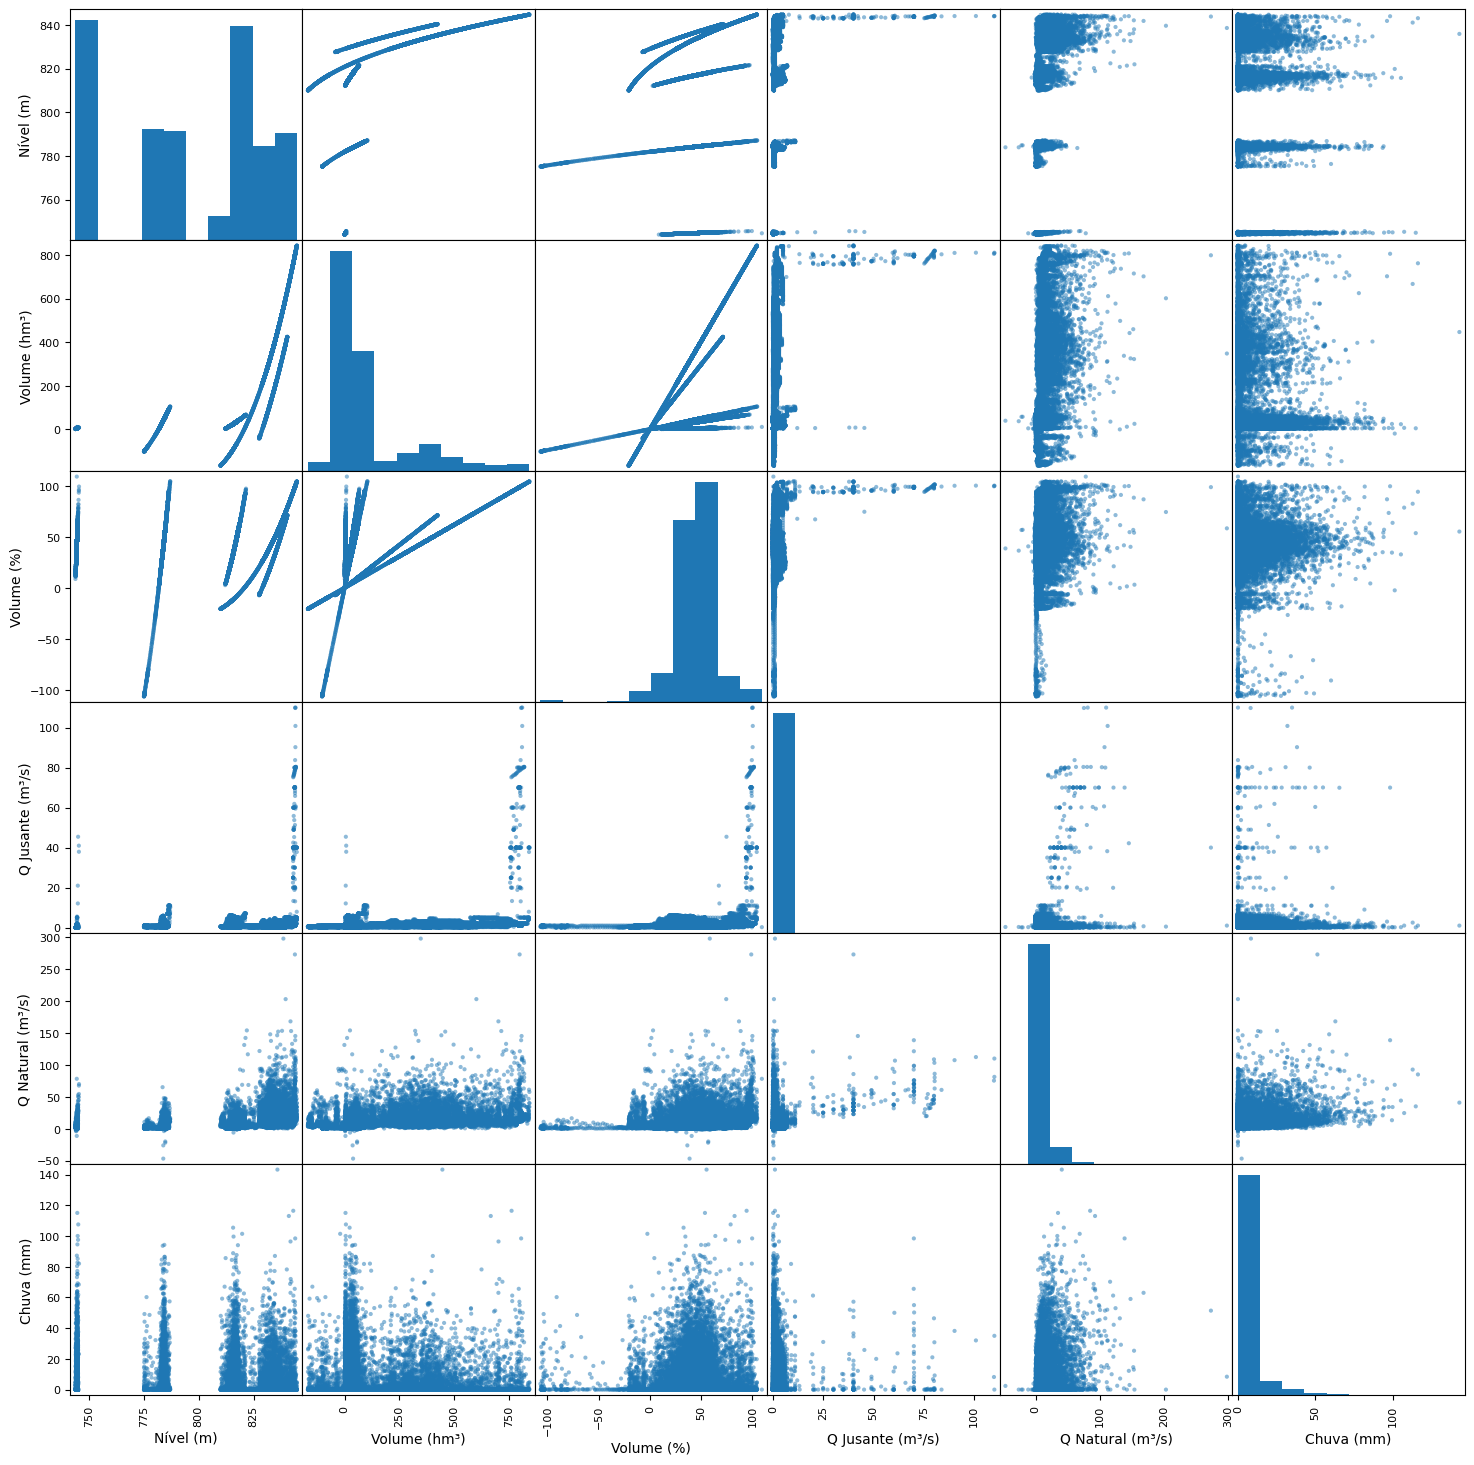

In [15]:
pd.plotting.scatter_matrix(df_SABESP, figsize=(18,18))

plt.show()

In [8]:
dfSabesp = df_SABESP.groupby(['Data'], as_index=False).sum(numeric_only=True)

In [9]:
dfSabesp

,Data,Nível (m),Volume (hm³),Volume (%),Q Jusante (m³/s),Q Natural (m³/s),Chuva (mm)
0,2000-01-01,3181.83,364.889117,173.856164,10.16,70.885286,123.6
1,2000-01-02,3182.31,370.080351,195.805609,10.18,94.863726,116.4
2,2000-01-03,3182.55,376.466840,192.263964,7.29,108.207695,140.7
3,2000-01-04,3182.90,387.326973,189.617341,6.34,162.935989,74.9
4,2000-01-05,3183.43,402.462028,188.935016,6.33,211.604248,103.6
...,...,...,...,...,...,...,...
8486,2023-03-27,3187.46,795.162116,180.094749,1.85,42.724010,22.4
8487,2023-03-28,3187.47,796.396238,180.172835,1.85,40.153825,0.0
8488,2023-03-29,3187.36,797.084667,179.183104,1.85,35.615927,1.2
8489,2023-03-30,3187.29,798.879778,179.783851,1.85,49.586739,55.2


In [10]:
dfSabesp['Mês'] = pd.DatetimeIndex(dfSabesp['Data']).month

In [11]:
Volume = dfSabesp.groupby(['Mês']).mean(numeric_only=True)

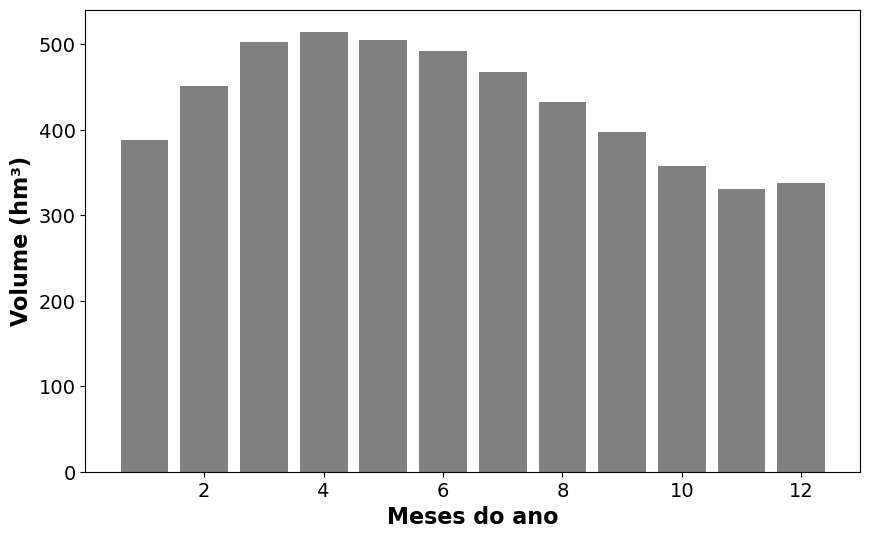

In [14]:
plt.figure(figsize=(10,6)) 
plt.rcParams['font.size'] = '14'
plt.bar(Volume.index, Volume['Volume (hm³)'].values, color='gray')
plt.xlabel('Meses do ano', weight = 'bold', fontsize=16) 
plt.ylabel('Volume (hm³)', weight = 'bold', fontsize=16)
plt.show()

In [15]:
Chuva = dfSabesp.groupby(['Mês']).mean(numeric_only=True)

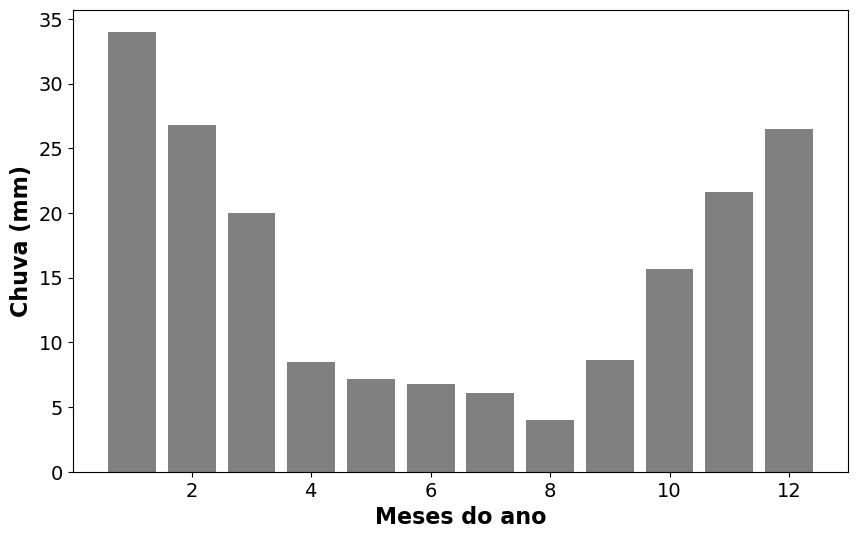

In [16]:
plt.figure(figsize=(10,6)) 
plt.rcParams['font.size'] = '14'
plt.bar(Chuva.index, Chuva['Chuva (mm)'].values, color='gray')
plt.xlabel('Meses do ano', weight = 'bold', fontsize=16) 
plt.ylabel('Chuva (mm)', weight = 'bold', fontsize=16)
plt.show()

In [17]:
media_movel = dfSabesp['Volume (hm³)'].rolling(30).mean()

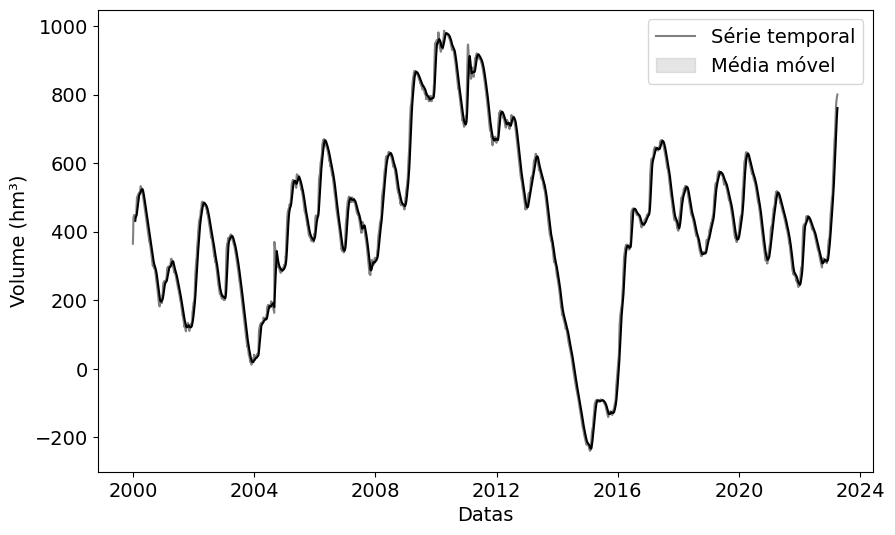

In [18]:
plt.figure(figsize=(10,6))
plt.rcParams['font.size'] = '14'

sns.lineplot(x='Data', y='Volume (hm³)', data=dfSabesp, color='gray')
plt.xlabel('Datas')
plt.ylabel('Volume (hm³)')


sns.lineplot(x='Data', y=media_movel, data=dfSabesp, color='black')
plt.legend(labels=['Série temporal', 'Média móvel'])
plt.show()

In [19]:
media_movel = dfSabesp['Chuva (mm)'].rolling(30).mean()

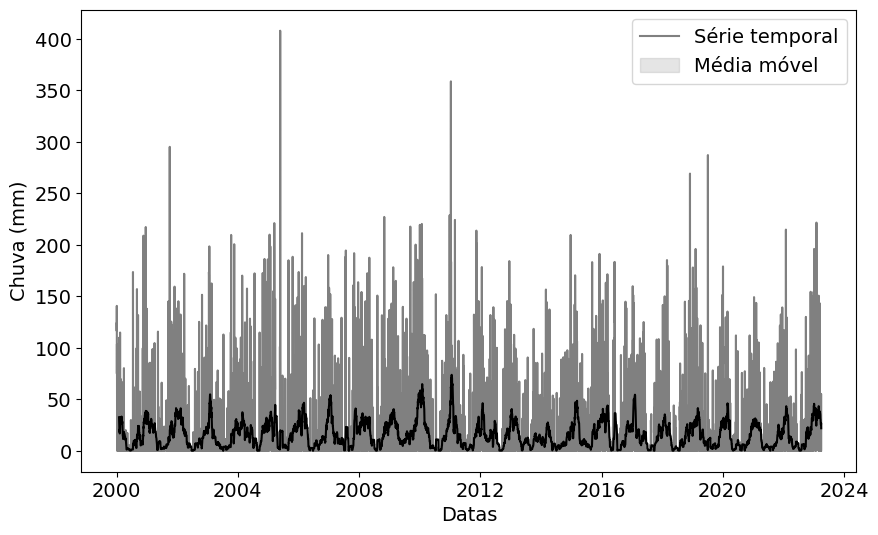

In [20]:
plt.figure(figsize=(10,6))
plt.rcParams['font.size'] = '14'

sns.lineplot(x='Data', y='Chuva (mm)', data=dfSabesp, color='gray')
plt.xlabel('Datas')
plt.ylabel('Chuva (mm)')


sns.lineplot(x='Data', y=media_movel, data=dfSabesp, color='black')
plt.legend(labels=['Série temporal', 'Média móvel'])
plt.show()

### Previsão do volume (hm³) dos reservatórios do sistema Cantareira

In [21]:
df1 = pd.DataFrame()

In [22]:
df1['ds'] = dfSabesp['Data']
df1['y'] = dfSabesp['Volume (hm³)']

In [23]:
df1

,ds,y
0,2000-01-01,364.889117
1,2000-01-02,370.080351
2,2000-01-03,376.466840
3,2000-01-04,387.326973
4,2000-01-05,402.462028
...,...,...
8486,2023-03-27,795.162116
8487,2023-03-28,796.396238
8488,2023-03-29,797.084667
8489,2023-03-30,798.879778


In [25]:
modelo1 = Prophet()
modelo1.fit(df1)
DataFrameFuturo1  = modelo1.make_future_dataframe(periods=730, freq = 'd')
previsao1 = modelo1.predict(DataFrameFuturo1)

18:19:17 - cmdstanpy - INFO - Chain [1] start processing
18:19:25 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
previsao1 = modelo1.predict(DataFrameFuturo1)
#previsao['yhat'] = previsao['yhat'].astype('int64')

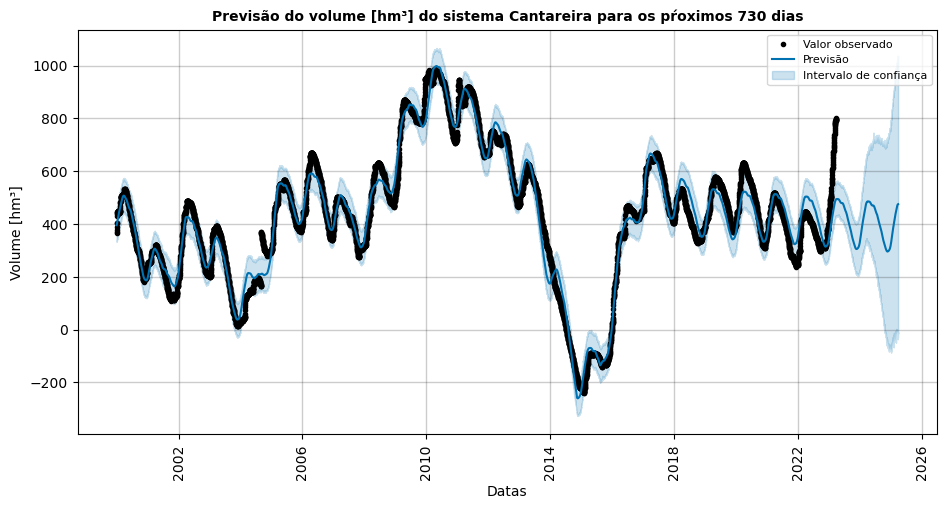

In [46]:
modelo1.plot(previsao1, figsize=(10, 5))
plt.title('Previsão do volume [hm³] do sistema Cantareira para os pŕoximos 730 dias',
          loc='center', color='black', fontweight='bold', fontsize=10)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.xlabel('Datas', fontsize=10)
plt.ylabel('Volume [hm³]', fontsize=10)

plt.legend(labels=['Valor observado', 'Previsão','Intervalo de confiança'],fontsize=8)
plt.grid(color='k', linestyle='solid', linewidth=1)
plt.show()

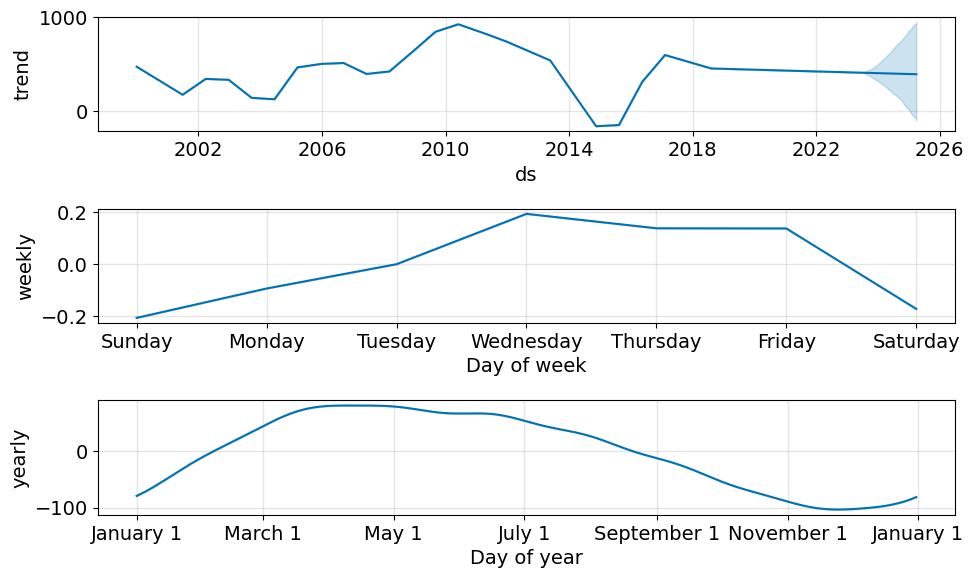

In [40]:
modelo1.plot_components(previsao1, figsize=(10,6))

### Previsão do chuva (mm) dos reservatórios do sistema Cantareira

In [31]:
df2 = pd.DataFrame()

In [32]:
df2['ds'] = dfSabesp['Data']
df2['y'] = dfSabesp['Chuva (mm)']

In [33]:
df2

,ds,y
0,2000-01-01,123.6
1,2000-01-02,116.4
2,2000-01-03,140.7
3,2000-01-04,74.9
4,2000-01-05,103.6
...,...,...
8486,2023-03-27,22.4
8487,2023-03-28,0.0
8488,2023-03-29,1.2
8489,2023-03-30,55.2


In [34]:
modelo2 = Prophet()
modelo2.fit(df2)
DataFrameFuturo2  = modelo2.make_future_dataframe(periods=730, freq = 'd')
previsao2 = modelo2.predict(DataFrameFuturo2)

18:20:59 - cmdstanpy - INFO - Chain [1] start processing
18:21:01 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
previsao2 = modelo2.predict(DataFrameFuturo2)
#previsao['yhat'] = previsao['yhat'].astype('int64')

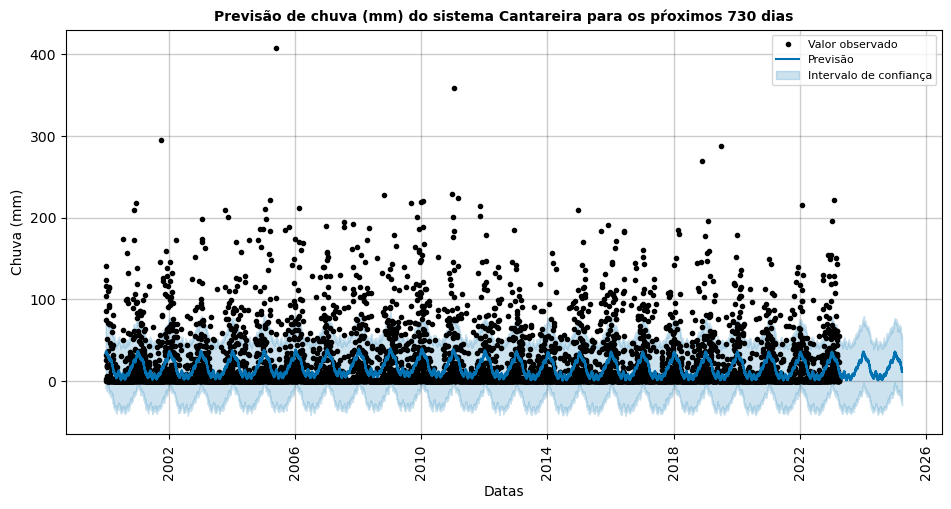

In [47]:
modelo2.plot(previsao2, figsize=(10, 5))
plt.title('Previsão de chuva (mm) do sistema Cantareira para os pŕoximos 730 dias',
          loc='center', color='black', fontweight='bold', fontsize=10)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.xlabel('Datas', fontsize=10)
plt.ylabel('Chuva (mm)', fontsize=10)

plt.legend(labels=['Valor observado', 'Previsão','Intervalo de confiança'],fontsize=8)
plt.grid(color='k', linestyle='solid', linewidth=1)
plt.show()

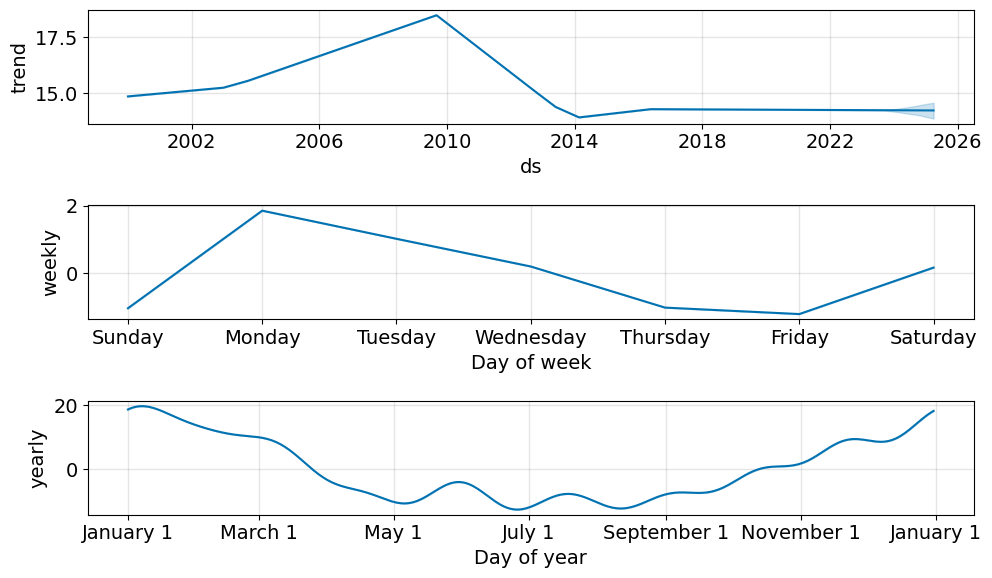

In [44]:
modelo2.plot_components(previsao2, figsize=(10,6))

### Tratamento do dataset

In [52]:
from bs4 import BeautifulSoup

def convert_to_xlsx():
    with open(r'/sistemas_produtores (1) 01jan22 a 30jun22.xls','r') as xml_file:
        soup = BeautifulSoup(xml_file.read(), 'xml')
        writer = pd.ExcelWriter(r'/sistemas_produtores (1) 01jan22 a 30jun22.xlsx')
        for sheet in soup.findAll('Worksheet'):
            sheet_as_list = []
            for row in sheet.findAll('Row'):
                sheet_as_list.append([cell.Data.text if cell.Data else '' for cell in row.findAll('Cell')])
            pd.DataFrame(sheet_as_list).to_excel(writer, sheet_name=sheet.attrs['ss:Name'], index=False, header=False)

        writer.save()

In [54]:
convert_to_xlsx()

In [7]:
Data = datetime.now().strftime('%Y%m%d')

df = pd.concat(map(pd.read_excel, glob.glob(
    r'/Preprocessamento/*.xlsx')))

df.to_excel(r'/Preprocessamento/' +
            Data + '_SABESP-istemas_produtores.xlsx', index=False)